<a href="https://colab.research.google.com/github/bhopchi/brain_tumor_MRI/blob/main/Bone_Fracture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

**Define Paths to Dataset Directories**

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/versions/2


In [35]:
# Define the paths to the datasets
data_dir = Path('Bone_Fracture/')
train_dir = data_dir / '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
test_dir = data_dir / '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
val_dir = data_dir / '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'

#  Define Parameters

In [36]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

#  Load the Datasets

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 506 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [38]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

In [39]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot some images from both class

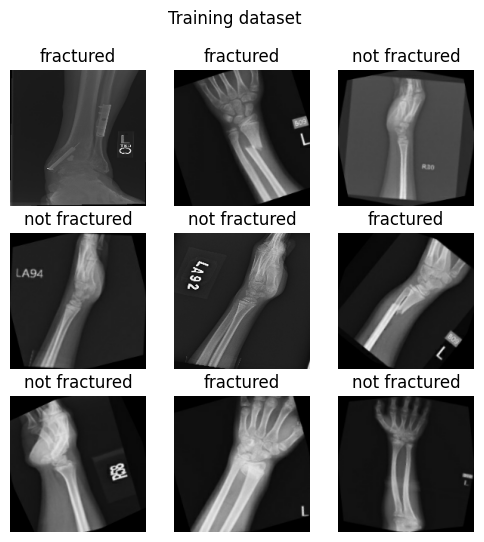

In [40]:
show_images(train_ds, 'Training dataset')

#  Plot class distributions

In [41]:
def count_classes(dataset, class_name):
    return len(list(Path.glob(dataset, f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

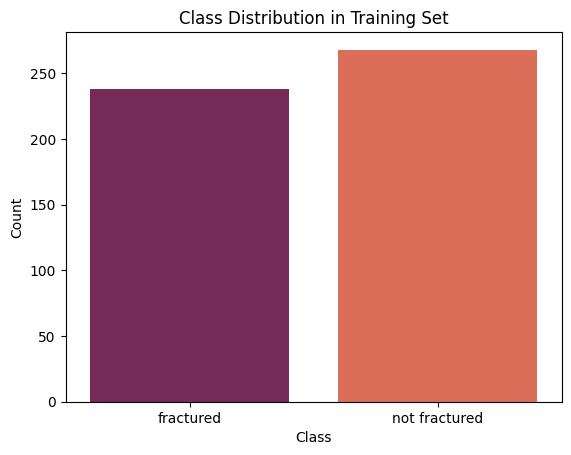

In [42]:
train_df = create_class_counts_df(train_dir, class_names)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

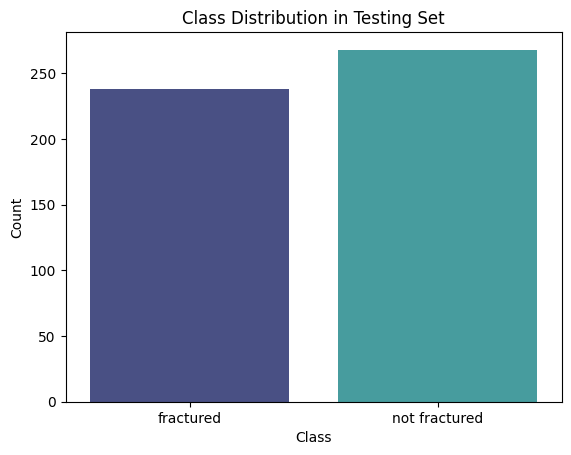

In [43]:
test_df = create_class_counts_df(test_dir, class_names)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

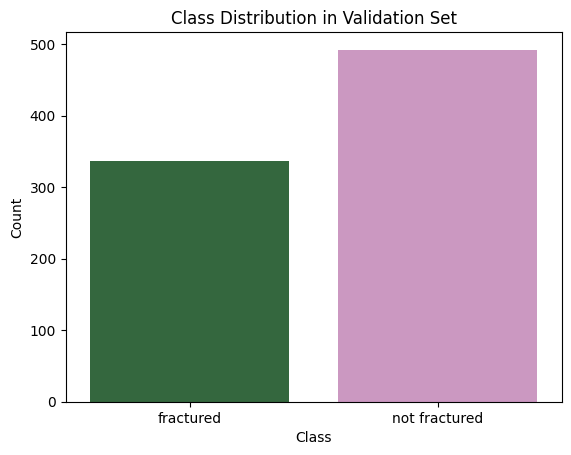

In [44]:
val_df = create_class_counts_df(val_dir, class_names)
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='cubehelix')

# Set Up Data Generators

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 506 images belonging to 2 classes.


In [47]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 506 images belonging to 2 classes.


In [48]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 829 images belonging to 2 classes.


# Define the Model

In [49]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#  Compile the Model

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the Model

In [65]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.8603 - loss: 0.3071 - val_accuracy: 0.8715 - val_loss: 0.3006
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8506 - loss: 0.3100 - val_accuracy: 0.8360 - val_loss: 0.3250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.8622 - loss: 0.2995 - val_accuracy: 0.8775 - val_loss: 0.2844
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9086 - loss: 0.2431 - val_accuracy: 0.9249 - val_loss: 0.2020
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9073 - loss: 0.2588 - val_accuracy: 0.9308 - val_loss: 0.2087
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9148 - loss: 0.2205 - val_accuracy: 0.9407 - val_loss: 0.1730
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9038 - loss: 0.2484 - val_accuracy: 0.9209 - val_loss: 0.2169
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9011 - loss: 0.2151 - val_accuracy: 0.9012 - val_loss:

# Evaluate the Model on the Test Dataset

In [70]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 987ms/step - accuracy: 0.9160 - loss: 0.2249
Test Accuracy: 0.92
Test Loss: 0.17


# Plot Training and Validation Accuracy and Loss

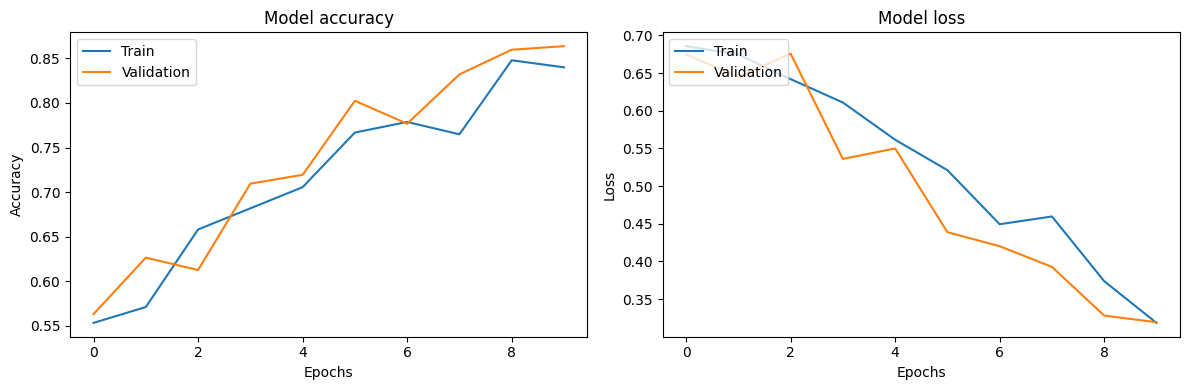

In [54]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Save the Model

In [56]:
model.save('fracture_classification_model.h5')

# Load the Model

In [57]:
loaded_model = tf.keras.models.load_model('fracture_classification_model.h5')

# Load and Preprocess Custom Image

In [63]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = '/content/83-rotated2-rotated1-rotated3.jpg'
preprocessed_img = load_preprocessed_image(image_path)

# Make Predictions on Custom Image

In [64]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  # Assuming categorical output
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted class: fractured
